# Rebalance XRP Spot only
    - xrp ซื้อขายได้ขั้นต่ำ 1 unit 2 3 ไม่มีทศนิยม 

In [1]:
import csv
import ccxt
import json
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import dates
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
class RebalanceFTX():
    
    def __init__(self, api_key, api_secret, subaccount=None, symbol=None, post_only=False):
        self.api_key = api_key
        self.api_secret = api_secret
        self.subaccount = subaccount
        self.symbol = symbol
        self.post_only = post_only
        self.exchange = ccxt.ftx({
            'apiKey' : api_key, 
            'secret' : api_secret,
            'enableRateLimit' : True})
        
        if self.subaccount == None:
            print('-' * 16)
            print('FTX Main Account')
            print('-' * 16)
            
        else:
            self.exchange.headers = {
                'FTX-SUBACCOUNT': self.subaccount,}
            print('-' * 26)
            print(f'FTX Sub Account : {self.subaccount}')
            print('-' * 26)
              
    
    def fetchPrice(self):
        pair = self.symbol
        try:
            price = float(self.exchange.fetch_ticker(pair)['last'])
        except ccxt.NetworkError as e:
            price = float(self.exchange.fetch_ticker(pair)['last'])
        except ccxt.ExchangeError as e:
            price = float(self.exchange.fetch_ticker(pair)['last'])
        except Exception as e:
            price = float(self.exchange.fetch_ticker(pair)['last'])
        return price
    
    def executeOrder(self, types, side, unit, price):
        # (pair, "limit", "buy", 0.001, 51000)
        pair = self.symbol
 
        try:
            order = self.exchange.create_order(pair, types, side, unit, price, params={'postOnly':self.post_only}) 
            print(f'{side} {types}: {pair} price: {price} unit: {unit}') 
        except:
            print('Pending failed')
            
 
    def fetchPending(self):
        pair = self.symbol
        dfPending = pd.DataFrame(self.exchange.fetch_open_orders(pair, since=None, limit=1000, params={}), 
                     columns=['id', 'timestamp', 'datetime', 'symbol', 'side', 'price', 'amount', 'status', 'filled'])
        return dfPending
    
    def fetchTradeHistory(self, since=None):
        pair = self.symbol
        dfHist = pd.DataFrame(self.exchange.fetch_my_trades(pair, since=since, limit=1000, params={}),
                     columns=['id', 'timestamp', 'datetime', 'symbol', 'side', 'price', 'amount', 'cost', 'fee'])
        
        #ftx.fetchOrderHistory()['fee'].iloc[0]['cost'] 
        return dfHist
        
    def cancelAllOrder(self):
        order_id = self.fetchPending()['id']
        for i in order_id:
            try:
                self.exchange.cancel_order(i) 
                print(f'Order ID : {i} has been cancelled')
            except:
                print('Cancel failed')
        
    def fetchBalance(self):
        return self.exchange.fetch_balance(params={})
    
    def fetchOrder(self, order_id):
        # d = 'status' ,'filled' ,'price etc', 'side'.
        return self.exchange.fetch_order(order_id)
    
    def OHLCV(self, tf, limit=None):
        #tf = '15s', '1m', '5m', '15m', '1h', '4h', '1d'
        pair = self.symbol
        ohlcv = self.exchange.fetch_ohlcv(pair, timeframe=tf, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        return df
    
    def minimumSize(self):
        pair = self.symbol
        min_size = self.exchange.fetch_ticker(pair)['info']['minProvideSize']
        return min_size
    
    def rebalance(self, min_diff, fixed, rp): 
        # rebalance every diff% value asset
        # fixed=asset value fixed
        # rp = risk parameter (first entry buy)
        quote = self.symbol.split('/')[1]
        based = self.symbol.split('/')[0]
        
        price = self.fetchPrice()
        cash = self.fetchBalance()[quote]['total']
        asset = self.fetchBalance()[based]['total']
 
        asset_val = asset*price
        diff = asset_val - fixed
        print(f'Asset:{asset:.4f} x Price:{price:.5f} = Value:{asset_val:.4f} ==> Diff:{diff:.4f} {quote}, Size:{diff/price:.2f} {based}')
        
        mdf = min_diff*fixed 
        #rebalance every 2% of diff asset value
        
        #Sell
        if diff>mdf: 
            if self.fetchPending().empty: 
                pass
            else:
                self.cancelAllOrder()
 
            unit = int(diff/price)
            #print(f'sell {unit} xrp @{round(price+price*0.001,6)}')
            self.executeOrder('limit', 'sell', unit, round(price+price*0.0006,6))
 
        #Buy
        elif abs(diff)>mdf and price<=rp: 
            if self.fetchPending().empty:
                pass
            else:
                self.cancelAllOrder()
 
            unit = int(abs(diff)/price)
            #print(f'buy {unit} xrp @{round(price-price*0.001,6)}')
            self.executeOrder('limit', 'buy', unit, round(price-price*0.0006,6))
        else:
            print('Wait !!!')
            

In [4]:
ftx = RebalanceFTX(api_key='_QEWMUNqNgtihs1B8_T_vAe776u6kdAu9Qt6MUuC',
                   api_secret='aZgCW4MDIvIgai-lOpfuJJqi3rj01TTnkX7ZUJCi',
                   subaccount='XRP001',
                   symbol='XRP/USD',
                   post_only=True)

--------------------------
FTX Sub Account : XRP001
--------------------------


In [5]:
'''# Rebalance params
tb = 300 # Rebalance 1 hr = 3600 sec
min_diff = 0.02 # 2% diff value asset
fixed = 100 # fixed asset value
rp = 0.8911 # Risk parameter
 
while True:
        
    ftx.rebalance(min_diff, fixed, rp)
    print(f'Sleep {tb} sec.')
        
    time.sleep(tb)'''

"# Rebalance params\ntb = 300 # Rebalance 1 hr = 3600 sec\nmin_diff = 0.02 # 2% diff value asset\nfixed = 100 # fixed asset value\nrp = 0.8911 # Risk parameter\n \nwhile True:\n        \n    ftx.rebalance(min_diff, fixed, rp)\n    print(f'Sleep {tb} sec.')\n        \n    time.sleep(tb)"

# Cashflow calulate
    - Exchange FTX
    - Product XRP
    - Capital	6000	THB 
    - Cash	89.45	USD
    - Risk parameter 0.8911	USD
    - Mark Unit	113.1889	XRP
    - Value	100.8626	USD
    - Port Value	190.30	USD
    - Start date	15/6/2021	

In [5]:
class calulateLIFO():
    
    def __init__(self, data): # 'side', 'price, 'amount(unit)'
        self.orderhis = data
        self.lifo_price = []
        self.lifo_unit = []
        self.total_cashflow = 0
        self.cum_cashflow = []
        self.fee = 0
        
        self.df_cf = None
        

    def buyinLIFO(self, buy_unit, buy_price):
        self.lifo_price.append(buy_price)
        self.lifo_unit.append(buy_unit)
        
      
    def soldoutLIFO(self, sold_unit, sold_price):
    
        sum_unit = 0
        list_unit = []
        list_price = []
          
        while  sum_unit < sold_unit:
            u = self.lifo_unit.pop()
            p = self.lifo_price.pop()
            sum_unit += u
            list_unit.append(u)
            list_price.append(p)
    
        for u, p in zip(list_unit, list_price):
            if u>sold_unit:
                cf = sold_unit*(sold_price-p) 
                self.total_cashflow += cf
                self.lifo_unit.append(u-sold_unit)
                self.lifo_price.append(p)
            else:
                cf = u*(sold_price-p) 
                self.total_cashflow += cf
                sold_unit-=u
        self.cum_cashflow.append(self.total_cashflow)
            

    def cashflowLIFO(self):
        order_his = self.orderhis
    
        for i in range(len(order_his)):
            if order_his['side'][i] == 'buy':
                self.buyinLIFO(order_his['amount'][i], order_his['price'][i])
            
            elif order_his['side'][i] == 'sell':
                self.soldoutLIFO(order_his['amount'][i], order_his['price'][i])
                
    def feeCalulate(self):
        order_his = self.orderhis
    
        for i in range(len(order_his)):
            if order_his['side'][i] == 'sell':
                self.fee += order_his['fee'].iloc[i]['cost']
    
    def cf_plot(self):
        
        df = self.orderhis
        
        # Set date range index
        s = df['datetime'][0].split('T')[0]
        e = df['datetime'][len(df)-1].split('T')[0]
        date_range = pd.date_range(start=s, end=e)
        
        # Get Cashflow from sell side only
        date_sell = df[df['side']=='sell']['datetime'].apply(lambda x: x.split('T')[0])
        cum_cf = pd.DataFrame(self.cum_cashflow, index=pd.to_datetime(date_sell)) # get cum_cf 
        
        # Change cum_cf to cf and groupby date
        cum_cf2 = cum_cf.shift()
        cum_cf2.iloc[0] = 0 
        cf = cum_cf - cum_cf2
        cf_per_day = cf.groupby('datetime').sum() 

        # df cashflow, cum cashflow
        df_cashflow = pd.DataFrame(date_range, columns=['datetime']).set_index('datetime')
        df_cashflow['Cashflow'] = cf_per_day
        df_cashflow = df_cashflow.fillna(0)
        df_cashflow['Cum_Cashflow'] = df_cashflow['Cashflow'].cumsum()
        self.df_cf = df_cashflow
        
        # Cashflow day of week
        df_cashflow['dayOfWeek'] = df_cashflow.index.day_name()
        dayOfWeek = df_cashflow.groupby(['dayOfWeek'],as_index=False)['Cashflow'].sum()
        cats = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        cf_dayOfWeek = dayOfWeek.set_index('dayOfWeek').reindex(cats)
        
        #df_cashflow['Cashflow'].groupby(pd.Grouper(freq='M')).sum()
        
        fig = plt.figure(figsize=(20, 25))
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)
        
        ax1.plot(df_cashflow['Cum_Cashflow'], color='darkturquoise', lw=2)
        ax1.title.set_text('Cumulative Cashflow')
        ax1.tick_params(axis='x', rotation=75)
        ax1.xaxis.set_major_locator(dates.DayLocator(interval=1))
        
        y = df_cashflow.reset_index()['Cashflow']
        x = df_cashflow.reset_index()['datetime']
        ax2.bar(x, y, color='orange')
        ax2.title.set_text('Cashflow per Days')
        ax2.tick_params(axis='x', rotation=75)
        ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
        
        ax3.bar(cf_dayOfWeek.reset_index()['dayOfWeek'], cf_dayOfWeek.reset_index()['Cashflow'], color='mediumpurple')
        ax3.title.set_text('Cashflow day of week')
        ax3.tick_params(axis='x', rotation=45, labelsize=12)
        ax3.xaxis.set_major_locator(dates.DayLocator(interval=1))
        
        
                  

In [6]:
# Trade his
df = ftx.fetchTradeHistory(since=1502962946216)

In [7]:
# Set first entry price & unit
cap = 190.31
cf_transfer = 8 # โอนไป main account แล้ว $7
df.loc[0, 'side'] = 'buy'
df.loc[0, 'price'] = 0.8911
df.loc[0, 'amount'] = 113.1889
df.loc[0, 'cost'] = 0.8911*113.1889

In [8]:
# for check acculate cf
#df = df.append({'side':'sell', 'price':0.8911, 'amount':27}, ignore_index=True)

In [9]:
cf = calulateLIFO(df)

In [10]:
# function for calculate cf,fee
cf.cashflowLIFO() # cashflow
cf.feeCalulate() # fee

Total Cashflow = $8.902 
4.678%


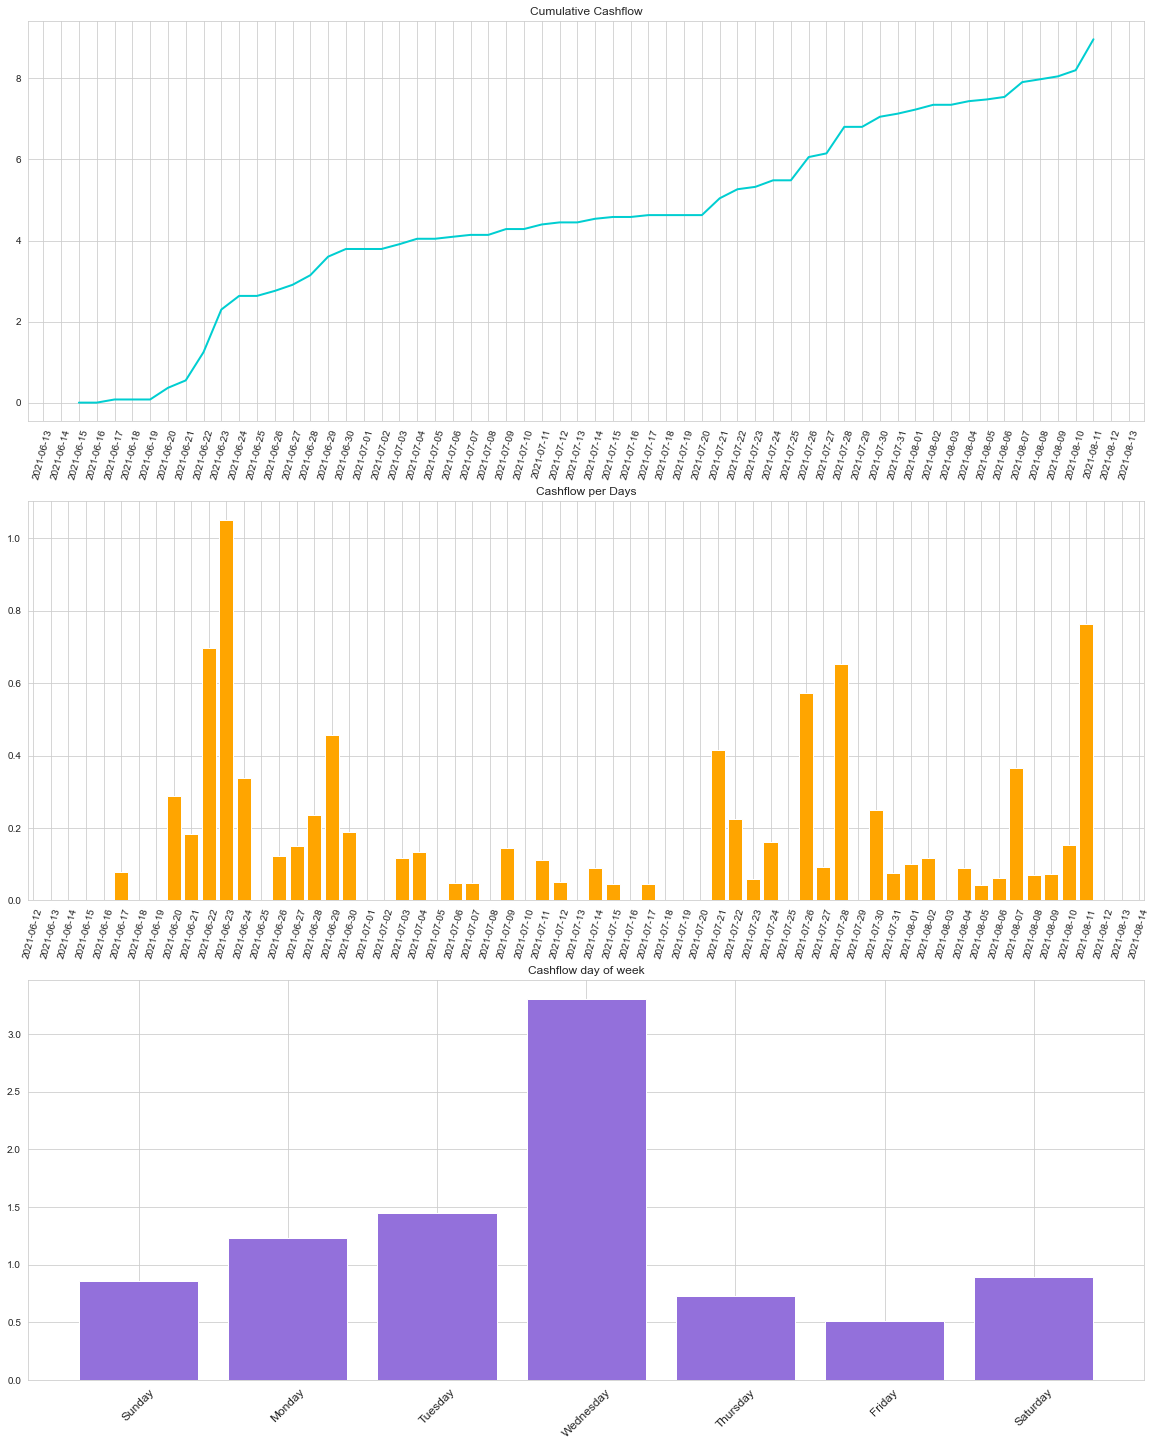

In [11]:
cf.cf_plot()
print(f'Total Cashflow = ${cf.total_cashflow - cf.fee:.3f} ')
print(f'{(cf.total_cashflow - cf.fee)/cap*100:.3f}%')
#plt.savefig('cf')

In [12]:
m_cf = cf.df_cf['Cashflow'].groupby(pd.Grouper(freq='M')).sum()/cap*100
m_cf

datetime
2021-06-30    1.991803
2021-07-31    1.754414
2021-08-31    0.964479
Freq: M, Name: Cashflow, dtype: float64

In [13]:
int(25.59)

25